In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets sentencepiece

In [10]:
import re
import torch

from PIL import Image

### 1. Loading processor and model

In [3]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")

2025-02-04 11:54:49.704108: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-04 11:54:49.705683: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-04 11:54:49.711165: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-04 11:54:49.725029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738650289.748903   32543 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738650289.75

config.json:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/803M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.donut.modeling_donut_swin.DonutSwinModel'> is overwritten by shared encoder config: DonutSwinConfig {
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    14,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "image_size": [
    2560,
    1920
  ],
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 4.0,
  "model_type": "donut-swin",
  "num_channels": 3,
  "num_heads": [
    4,
    8,
    16,
    32
  ],
  "num_layers": 4,
  "patch_size": 4,
  "path_norm": true,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0.dev0",
  "use_absolute_embeddings": false,
  "window_size": 10
}

Config of the decoder: <class 'transformers.models.mbart.modeling_mbart.MBartForCausalLM'> is overwritten by shared decoder config: MBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "a

### 2. Runtime

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Model running on '{device}'")
model.to(device)

pass

Model running on 'cpu'


In [9]:
processor

DonutProcessor:
- image_processor: DonutImageProcessor {
  "do_align_long_axis": false,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "do_thumbnail": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "DonutImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "processor_class": "DonutProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 2560,
    "width": 1920
  }
}

- tokenizer: XLMRobertaTokenizerFast(name_or_path='naver-clova-ix/donut-base-finetuned-docvqa', vocab_size=57522, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>', 'additional_special_tokens': ['</s_answer>', '</s_question>', '<no/>', '<s_answer>', '<s_docvqa>', '<s_iitcdip>'

### 3. Image data reading

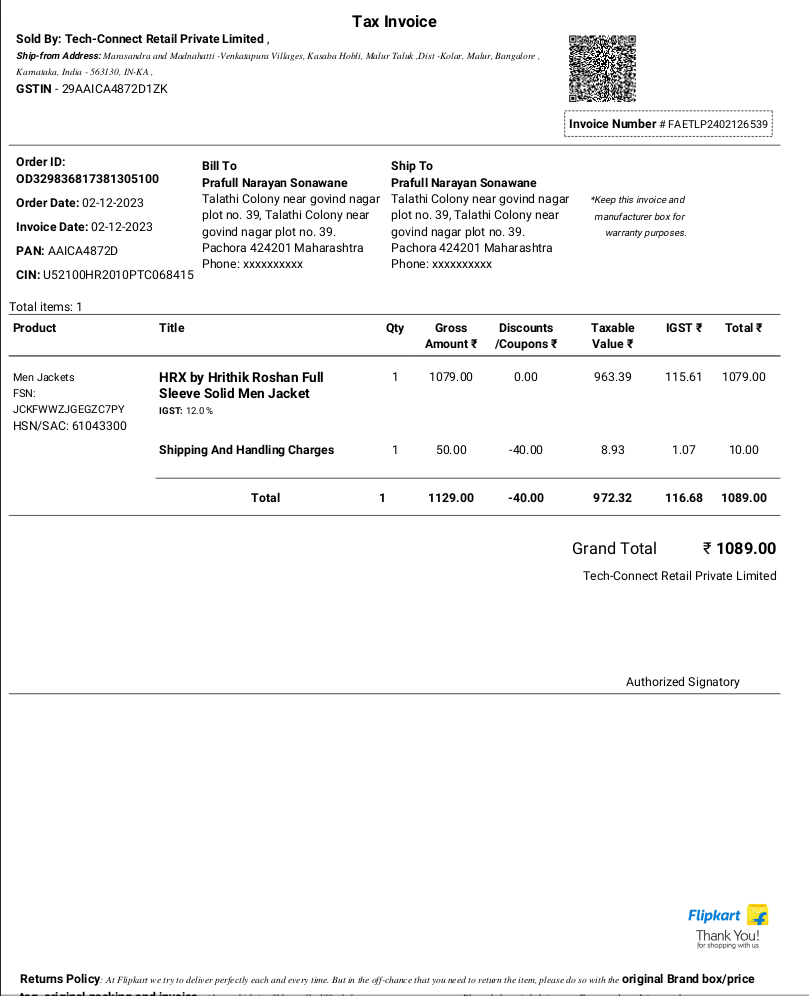

In [15]:
img_path = "./flipkart_recipt.png"
img = Image.open(img_path).convert("RGB")

img

### 4. Preprocessing -> Tokenization and Pixel Values

In [53]:
task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

pixel_values = processor(img, return_tensors="pt")['pixel_values']

### 5. Extracting data

In [54]:
outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

### 6. Decoder

In [55]:
sequence = processor.batch_decode(outputs.sequences)[0]

# Replacing Starting and Padding token with empty string
sequence = (
    sequence
    .replace(processor.tokenizer.eos_token, "")
    .replace(processor.tokenizer.pad_token, "")
)

sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()

### 7. Inferncing Function

In [84]:
def infernce_fn(invoice_path: str, question: str):

    img = Image.open(invoice_path).convert("RGB")

    task_prompt = "{user_input}"

    prompt = task_prompt.replace("{user_input}", question)

    decoder_input_ids = processor.tokenizer(prompt, add_special_tokens=False, return_tensors="pt").input_ids

    pixel_values = processor(img, return_tensors="pt")['pixel_values']

    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )


    sequence = processor.batch_decode(outputs.sequences)[0]

    # Replacing Starting and Padding token with empty string
    sequence = (
        sequence
        .replace(processor.tokenizer.eos_token, "")
        .replace(processor.tokenizer.pad_token, "")
    )

    sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()

    return processor.token2json(sequence)


In [85]:
infernce_fn(img_path, "what is CIN")

{'text_sequence': 'what is CIN: u52100hr201optc068415'}

In [86]:
infernce_fn(img_path, "what is PAN")

{'text_sequence': 'what is PAN-ACI-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105-105'}

In [88]:
infernce_fn(img_path, "what is Invoice Date")

{'text_sequence': 'what is Invoice Date:02-12-023'}

In [89]:
infernce_fn(img_path, "what is Order Date")

{'text_sequence': 'what is Order Date: 02-12-023'}

In [61]:
import os
import pandas as pd

invoices = (
    pd.DataFrame()
    .assign(
        file_path=os.listdir("./train"),
        invoices_paths=lambda df_: "./train/" + df_.file_path
    )

    .drop(columns=['file_path'])
)

invoices

,invoices_paths
0,./train/Invoice_64_gaussianblur.jpg
1,./train/Invoice_100.jpg
2,./train/Invoice_69.jpg
3,./train/Invoice_172_brightness.jpg
4,./train/Invoice_49.jpg
...,...
960,./train/Invoice_179_brightness.jpg
961,./train/Invoice_138_horizontallyflip.jpg
962,./train/Invoice_5_gaussianblur.jpg
963,./train/Invoice_92_affine_translation.jpg


In [64]:
(
    invoices['invoices_paths']
    .sample(5)
    .apply(infernce_fn)
)

128                     {'text_sequence': '</s_answer>'}
183                     {'text_sequence': '</s_answer>'}
163                   {'text_sequence': '4></s_answer>'}
151    {'text_sequence': '>>>>>>>>>>>>>>>>>>>>>>>>>>>...
394                     {'text_sequence': '</s_answer>'}
Name: invoices_paths, dtype: object